In [1]:
import numpy as np
import pandas as pd
import dataprocessing as dp
import loaddata


import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
#import helpfunctionfordata as hf
from tslearn.clustering import KShape
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import set_link_color_palette
from scipy.stats import norm, zscore
from scipy import stats
from numpy.fft import fft
import matplotlib.mlab as mlab
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns

import sympy as sy
from numpy import linalg
from scipy.optimize import minimize, Bounds, least_squares

%reload_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": '16'
})

In [2]:
dictseason,dictweekday=loaddata.dicts_season_weekday()

In [3]:
stationen=loaddata.load_stations()
display(stationen)

,Name,Hausanschluesse,Leistung,Cluster,Kurzname,Zaehler,LeistungproHA,LeistungproZaehler,ZaehlerproHA
0,Durchholz,73,400,W4,A,99,5.479452,4.040404,1.356164
1,Guennemannshof,62,400,W1,B,72,6.451613,5.555556,1.161290
2,Kaemperfeld,24,630,W3,C,40,26.250000,15.750000,1.666667
3,Lutherplatz,53,630,S,D,394,11.886792,1.598985,7.433962
4,Marienhospital alt,43,630,S,E,382,14.651163,1.649215,8.883721
5,Querweg,26,400,W2,F,50,15.384615,8.000000,1.923077
6,Rehnocken 1,19,200,W2,G,34,10.526316,5.882353,1.789474
7,Rudolf-Koenig-Strasse,40,630,S,H,315,15.750000,2.000000,7.875000
8,Schule Durchholz,53,400,W1,I,90,7.547170,4.444444,1.698113


In [4]:
list_power_d, list_power_yd, list_power_ysd, list_power_ymd, list_mat_power_d, list_power_ywd, list_power_yswd, list_power_only_d = loaddata.load_data_from_measurements([0,1,2,3,4,5,6,7,8], d=True, yd=True, ysd=True,ywd=True,yswd=True)

Lade Daten von Station  Durchholz
Lade Daten von Station  Guennemannshof
Lade Daten von Station  Kaemperfeld
Lade Daten von Station  Lutherplatz
Lade Daten von Station  Marienhospital alt
Lade Daten von Station  Querweg
Lade Daten von Station  Rehnocken 1
Lade Daten von Station  Rudolf-Koenig-Strasse
Lade Daten von Station  Schule Durchholz


In [5]:

ULC = pd.read_excel('econtrol_ulc.xlsx',header=0,index_col=0)

In [6]:
SLP_list=list()

#           0   1    2    3    4    5    6   7     8    9    10    11
for i in ['H0','G0','G1','G2','G3','G4','G5','G6','L0','L1','L2','econtrol_ulc']:
    if i == 'econtrol_ulc':
        slp=pd.read_excel(i + '.xlsx',header=0,index_col=0)
    else:
        slp=pd.read_excel(i + '.xlsx',header=(0,1),index_col=0)
    SLP_list.insert(len(SLP_list),slp)

`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 8.0425e+07, final cost 1.2461e+05, first-order optimality 1.91e-03.
[0.19400678 0.07498042 0.1074251  0.03309011 0.02367676]
`ftol` termination condition is satisfied.
Function evaluations 13, initial cost 8.4516e+07, final cost 8.8730e+04, first-order optimality 7.50e-04.
[1.50445707e-02 1.44811890e-13 1.48607684e-01 6.71572162e-02
 7.69001287e-02]
`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 8.6570e+07, final cost 1.9334e+06, first-order optimality 6.04e-05.
[1.19278141e-12 4.20681653e-10 4.61485247e-10 2.03613350e-01
 1.15849979e-01]
`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 6.1737e+07, final cost 1.0336e+05, first-order optimality 2.48e-04.
[0.1904216  0.01744057 0.23414059 0.28320963 0.24280823]
`gtol` termination condition is satisfied.
Function evaluations 14, initial cost 4.9625e+07, final cost 2.2843e+05, first-order optima

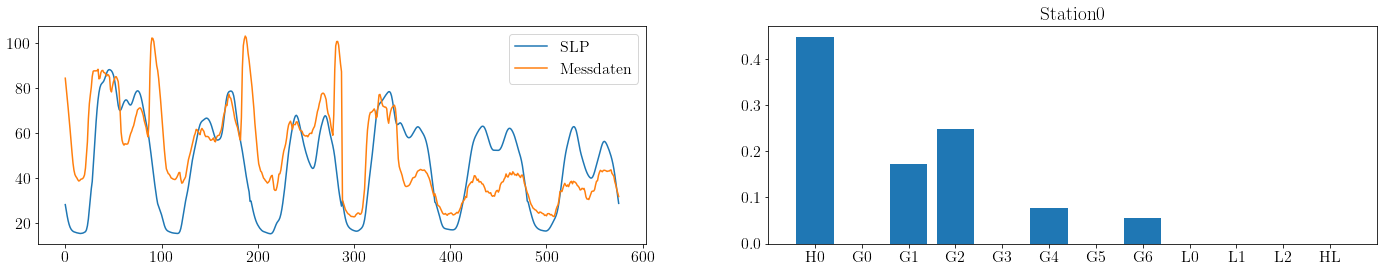

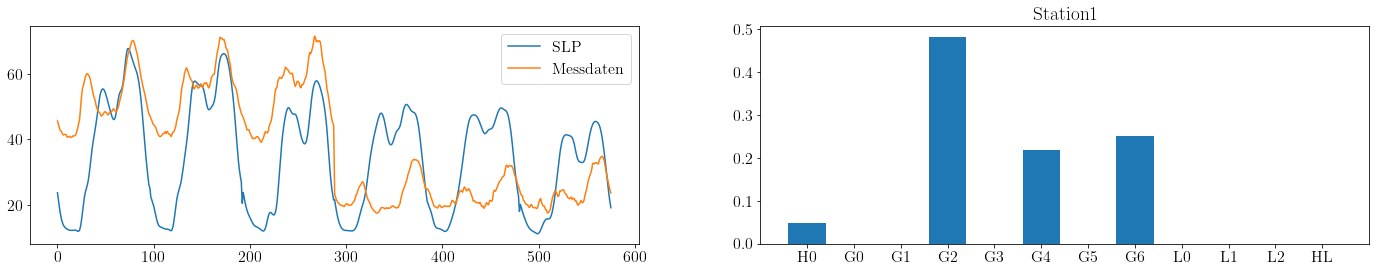

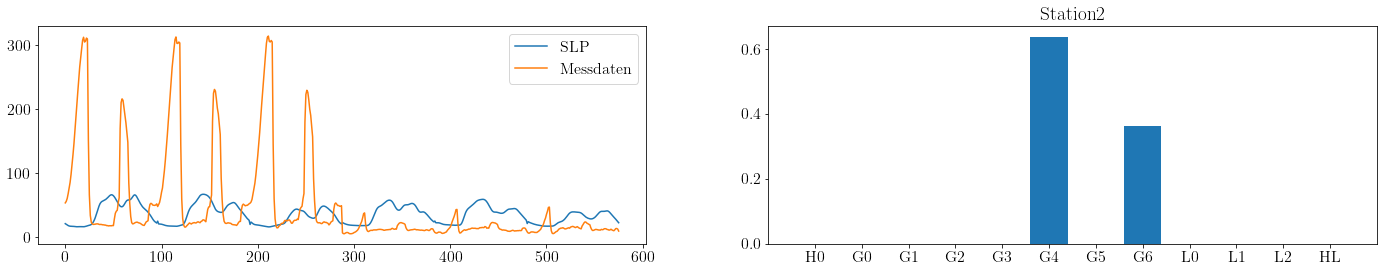

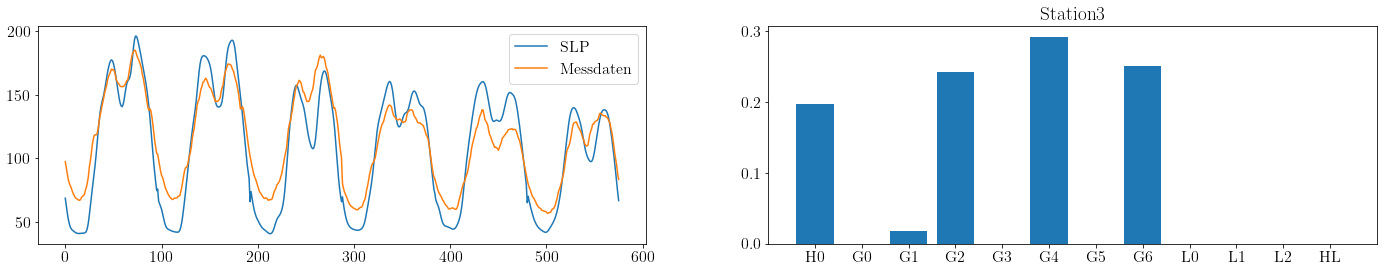

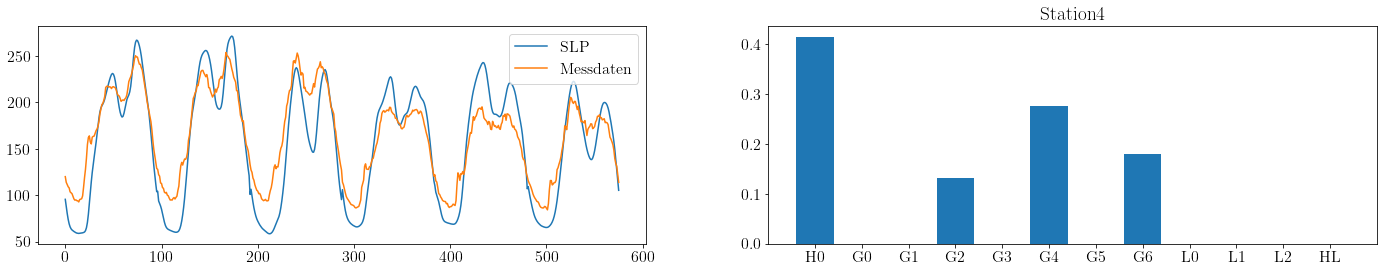

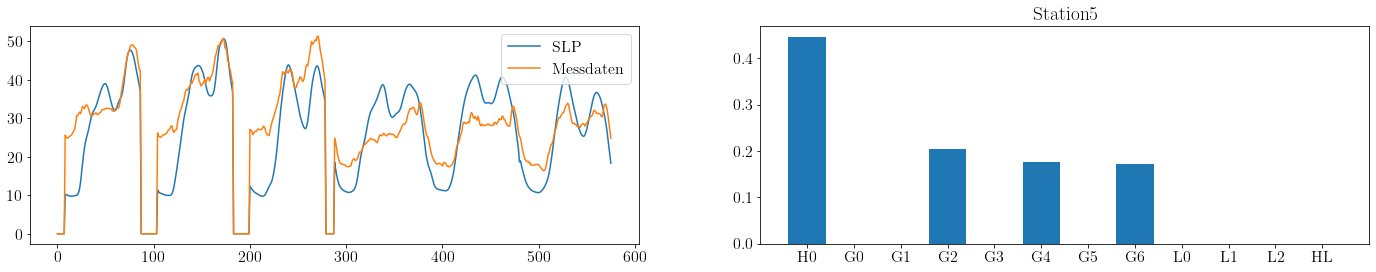

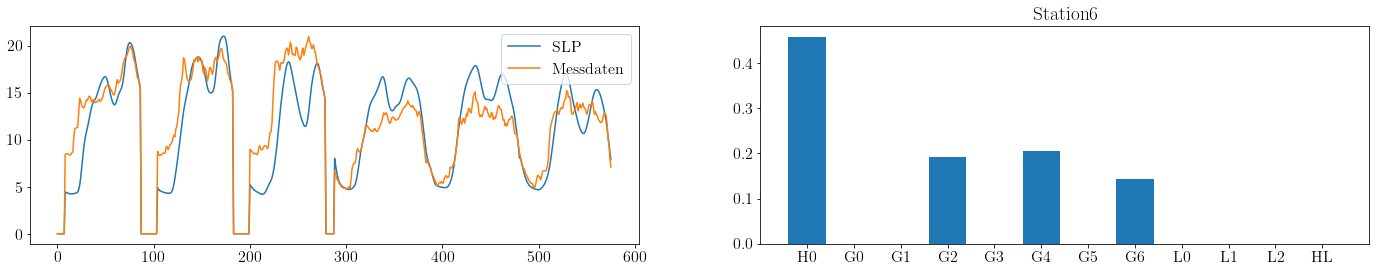

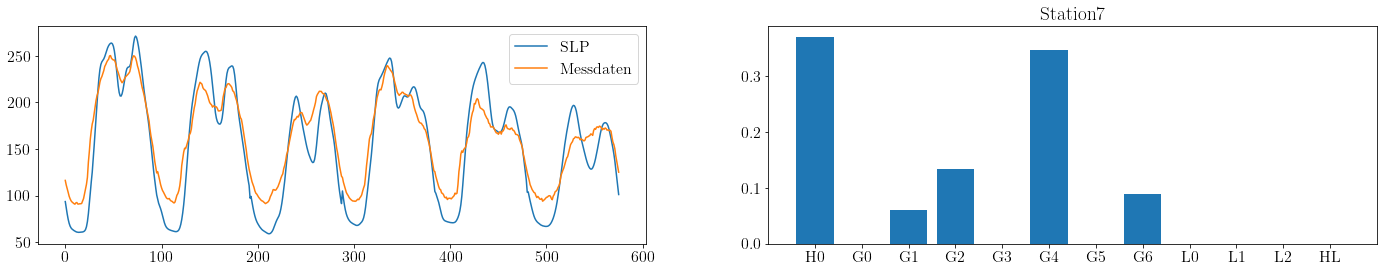

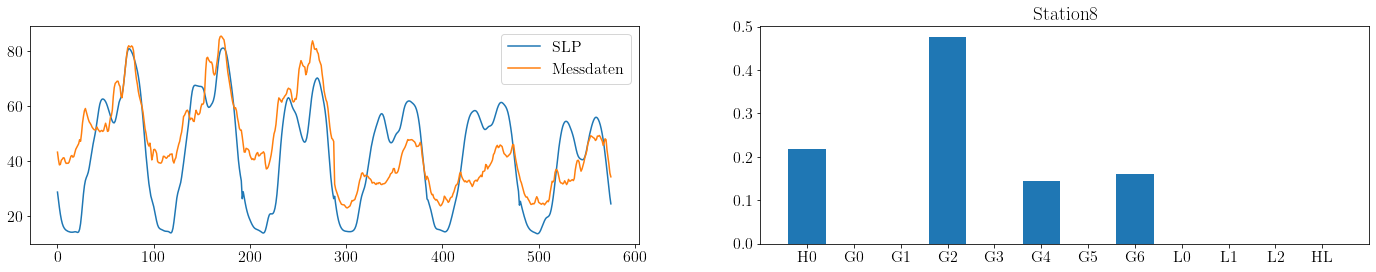

In [15]:
weekday=0
season=2
for station in range(0,9):
    typeday=np.zeros([6*96])
    typeday[0:96]=list_power_yswd[station][2018].loc[:,0].loc[:,0].mean(axis=1).to_numpy()
    typeday[96:192]=list_power_yswd[station][2018].loc[:,0].loc[:,1].mean(axis=1).to_numpy()
    typeday[192:288]=list_power_yswd[station][2018].loc[:,0].loc[:,2].mean(axis=1).to_numpy()
    if station == 5 or station == 6:
        typeday[87:96]=0
        typeday[183:192]=0
        typeday[279:288]=0
        typeday[96:104]=0
        typeday[192:200]=0
        typeday[0:8]=0
    typeday[288:384]=list_power_yswd[station][2018].loc[:,2].loc[:,0].mean(axis=1).to_numpy()
    typeday[384:480]=list_power_yswd[station][2018].loc[:,2].loc[:,1].mean(axis=1).to_numpy()
    typeday[480:576]=list_power_yswd[station][2018].loc[:,2].loc[:,2].mean(axis=1).to_numpy()
    ind=np.array([0,2,3,5,7])
    interesting_slp=np.zeros([6*96,ind.shape[0]])
    count=0
    for i in ind:
        if i == 11:
            interesting_slp[0:96,count]=SLP_list[i].loc[:,dictseason[0]].to_numpy()
            interesting_slp[96:192,count]=SLP_list[i].loc[:,dictseason[0]].to_numpy()
            interesting_slp[192:288,count]=SLP_list[i].loc[:,dictseason[0]].to_numpy()
            interesting_slp[288:384,count]=SLP_list[i].loc[:,dictseason[2]].to_numpy()
            interesting_slp[384:480,count]=SLP_list[i].loc[:,dictseason[2]].to_numpy()
            interesting_slp[480:576,count]=SLP_list[i].loc[:,dictseason[2]].to_numpy()
        else:
            interesting_slp[0:96,count]=SLP_list[i].loc[:,dictseason[0]].loc[:,dictweekday[0]].to_numpy()
            interesting_slp[96:192,count]=SLP_list[i].loc[:,dictseason[0]].loc[:,dictweekday[1]].to_numpy()
            interesting_slp[192:288,count]=SLP_list[i].loc[:,dictseason[0]].loc[:,dictweekday[2]].to_numpy()
            interesting_slp[288:384,count]=SLP_list[i].loc[:,dictseason[2]].loc[:,dictweekday[0]].to_numpy()
            interesting_slp[384:480,count]=SLP_list[i].loc[:,dictseason[2]].loc[:,dictweekday[1]].to_numpy()
            interesting_slp[480:576,count]=SLP_list[i].loc[:,dictseason[2]].loc[:,dictweekday[2]].to_numpy()
        if station == 5 or station == 6:
            interesting_slp[87:96]=0
            interesting_slp[183:192]=0
            interesting_slp[279:288]=0
            interesting_slp[0:8]=0
            interesting_slp[96:104]=0
            interesting_slp[192:200]=0
        count=count+1

    def model(x,S):
        return np.dot(S,x)

    def fun(x,S,y):
        return model(x,S)-y

    def jac(x,S,y):
        return S

    S=interesting_slp
    vec_y = typeday
    x0 = np.ones(len(ind))

    res = least_squares(fun,x0, jac=jac,bounds=(0,np.inf),args=(S,vec_y), verbose=1)

    subfig, axs=plt.subplots(1,2,figsize=(24,4))
    Z=np.dot(interesting_slp,res.x)
    axs[0].plot(Z)
    axs[0].plot(vec_y)
    axs[0].legend(['SLP','Messdaten'])
    summe=np.sum(res.x)
    anteile=res.x/summe
    axs[1].bar(ind,anteile)
    axs[1].set_xticks(np.arange(0,12),['H0','G0','G1','G2','G3','G4','G5','G6','L0','L1','L2','HL'])
    axs[1].set_xlim([-1,12])
    plt.title('Station' + str(station))
    print(res.x)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [115]:
res = least_squares(fun,x0, jac=jac,bounds=(0,np.inf),args=(S,vec_y), verbose=1)

`gtol` termination condition is satisfied.
Function evaluations 10, initial cost 3.4060e+07, final cost 4.6256e+04, first-order optimality 7.11e-09.


(-1.0, 11.0)

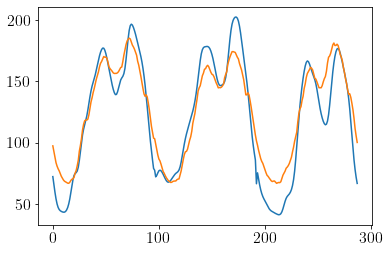

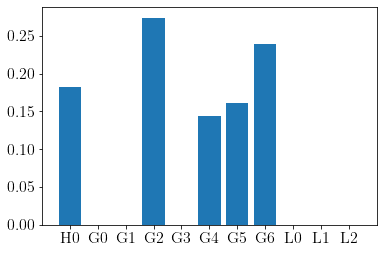

In [116]:
Z=np.dot(interesting_slp,res.x)
plt.plot(Z)
plt.plot(vec_y)
plt.figure()
summe=np.sum(res.x)
anteile=res.x/summe
plt.bar(ind,anteile)
plt.xticks(np.arange(0,11),['H0','G0','G1','G2','G3','G4','G5','G6','L0','L1','L2'])
plt.xlim([-1,11])

Funktionen

Clustern

Stochastische Analyse

Lastprofile

907891.1017669201


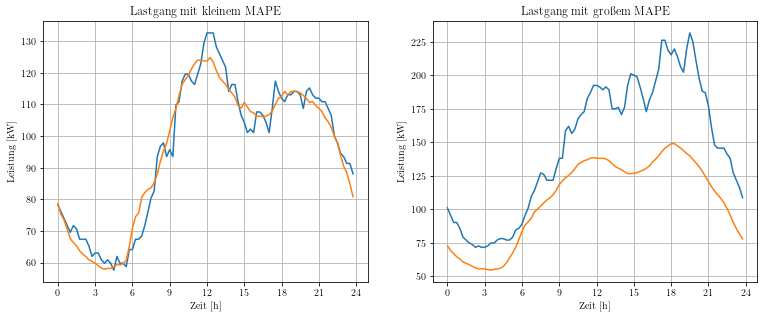

In [63]:
i=3

minimal=np.argmin(res_ges[i])
maximal=np.argmax(res_ges[i])
minimal_MAPE=np.min(res_ges[i])
maximal_MAPE=np.max(res_ges[i])
df_simulation = build_example_year(energy_factor[i]*load_profiles_list[group[i]],reg_polynoms_list[group[i]])
wide_simulation = np.reshape(df_simulation,[96,365],order='F')

YminMess = all_powers_year[i][2018].iloc[:,minimal].to_numpy()
YminSim = wide_simulation[:,minimal]

YmaxMess = all_powers_year[i][2018].iloc[:,maximal].to_numpy()
YmaxSim = wide_simulation[:,maximal]

subfig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
axs[0].plot(YminMess)
axs[0].plot(YminSim)
axs[0].set_title('Lastgang mit kleinem MAPE')
axs[0].set_xlabel('Zeit [h]')
axs[0].set_xticks(np.arange(0,108, step=12),np.arange(0,25, step=3))
axs[0].set_ylabel('Leistung [kW]')
axs[0].grid()

axs[1].plot(YmaxMess)
axs[1].plot(YmaxSim)
axs[1].set_title('Lastgang mit großem MAPE')
axs[1].set_xlabel('Zeit [h]')
axs[1].set_xticks(np.arange(0,108, step=12),np.arange(0,25, step=3))
axs[1].set_ylabel('Leistung [kW]')
axs[1].grid()
plt.savefig('statisch_vgl_tag.pdf',bbox_inches='tight')

In [ ]:
i=5
df_simulation = build_example_year(energy_factor[i]*load_profiles_list[group[i]],reg_polynoms_list[group[i]])
df_measure = all_powers_year[i][2018]

In [ ]:
plt.plot(df_measure.to_numpy()[:,50])
wide_simulation = np.reshape(df_simulation,[96,365],order='F')
plt.plot(wide_simulation[:,50])

Fragmente

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

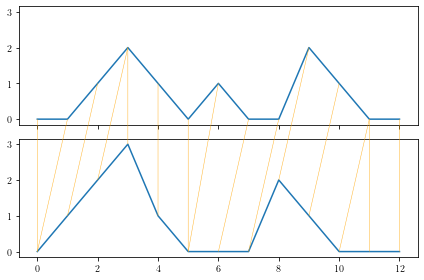

In [ ]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np

In [ ]:
def mahalanobis_distance(x,y,invC):
    return np.sqrt(np.dot(x.T,np.dot(invC,y)))

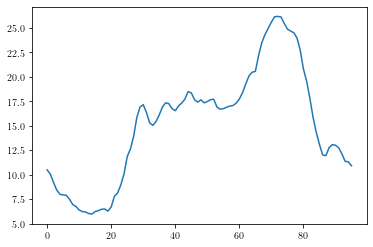

In [ ]:
plt.plot(np.std(all_powers_year[3][2018].to_numpy(),axis=1))